# To Be, Or Not To Be Project

Shakespeare is debatably the most prolific writer in all of history. He has written so many plays and has had such an impact on our culture and media that it is almost impossible to find a person who has never heard of his works. One reason for his popularity and success is how accessible his plays are, as all of them are in the public domain. Today, we will use Shakespeare's public works to practice **classification** problems, and determine what character is speaking what line just by using data and methods of classification.

## Retrieving the Data
This data comes from the [Shakespeare plays page on Kaggle](https://www.kaggle.com/kingburrito666/shakespeare-plays#Shakespeare_data.csv). We will begin by loading the dataset into a dataframe:

In [1]:
from os import path
import numpy as np
import pandas as pd

shakespeare_df = pd.read_csv("data/raw/Shakespeare_data.csv")
shakespeare_df.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


Let's run through some quick information about this dataset:

In [2]:
shakespeare_df.shape

(111396, 6)

In [3]:
shakespeare_df.keys()

Index(['Dataline', 'Play', 'PlayerLinenumber', 'ActSceneLine', 'Player',
       'PlayerLine'],
      dtype='object')

In [4]:
{"Play Titles": shakespeare_df["Play"].unique(), "Number of Plays": shakespeare_df["Play"].unique().size}

{'Play Titles': array(['Henry IV', 'Henry VI Part 1', 'Henry VI Part 2',
        'Henry VI Part 3', 'Alls well that ends well', 'As you like it',
        'Antony and Cleopatra', 'A Comedy of Errors', 'Coriolanus',
        'Cymbeline', 'Hamlet', 'Henry V', 'Henry VIII', 'King John',
        'Julius Caesar', 'King Lear', 'Loves Labours Lost', 'macbeth',
        'Measure for measure', 'Merchant of Venice',
        'Merry Wives of Windsor', 'A Midsummer nights dream',
        'Much Ado about nothing', 'Othello', 'Pericles', 'Richard II',
        'Richard III', 'Romeo and Juliet', 'Taming of the Shrew',
        'The Tempest', 'Timon of Athens', 'Titus Andronicus',
        'Troilus and Cressida', 'Twelfth Night', 'Two Gentlemen of Verona',
        'A Winters Tale'], dtype=object), 'Number of Plays': 36}

Wow, Shakespeare wrote a lot.

What do we know now about this dataset? Well, we know that in the *36* plays that are described in this dataset, we have a combined total of about **111,396** lines. Also, in order to continue using this dataset, we must understand what the columns describe:

|Key              |Description|
|:----------------|:----------|
|Dataline         |Index of the row in the dataset|
|Play             |Play that the given line is from|
|PlayerLinenumber |Number of line being spoken at a given time|
|ActSceneLine     |{Act Number}.{Scene Number}.{Line Number}|
|Player           |Character who is speaking the current line|
|PlayerLine       |The actual text of the line|

## Cleaning Up the Data
Let's make this dataset a little more manageable! Two really simple things we can do to make things cleaner are:
- Get rid of the `Dataline` column - that will not be necessary in our analysis
- Rename all of our columns to be cleaner

There is also a problem with certain rows when the `ActSceneLine` value is null or `Player` value is null:

In [5]:
shakespeare_df[shakespeare_df["ActSceneLine"].isnull() | shakespeare_df["Player"].isnull()].head(10)

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
111,112,Henry IV,10.0,NaN,WESTMORELAND,Exeunt
112,113,Henry IV,10.0,NaN,WESTMORELAND,SCENE II. London. An apartment of the Prince's.
113,114,Henry IV,10.0,NaN,WESTMORELAND,Enter the PRINCE OF WALES and FALSTAFF
214,215,Henry IV,33.0,NaN,FALSTAFF,Enter POINS
264,265,Henry IV,52.0,NaN,PRINCE HENRY,Exit Falstaff
299,300,Henry IV,61.0,NaN,POINS,Exit Poins
323,324,Henry IV,62.0,NaN,PRINCE HENRY,Exit


The problem arises when we encounter a stage direction (Scene change, character enter/exit, etc.). When these things happen, the `ActSceneLine`, `PlayerLineNumber`, and `Player` values make it seem like this is a spoken line of dialogue, even though it is not. We have two options here:
- We could find all instances of this error and set the `ActSceneLine`, `PlayerLineNumber`, and `Player` values to be null
- We could ignore these rows entirely

For this project, I will ignore these rows entirely, as our final goal is to predict what character is saying what, and if there is no character speaking at the given line, the information will be useless to our prediction.

One final thing we can do is split up all `ActSceneLine` values into their own separate columns of `act_number`, `scene_number`, and `line_number`. This will aid in our training later on in the analysis stage.

I will go ahead and do all of these conversions and save the results into a new csv file, as the conversions can take quite a long time on this big of a dataset:

In [6]:
# Check if we have already cleaned the data:
if not path.exists("data/interim/shakespeare_data_cleaned.csv"):

    # If not, start by dropping the Dataline
    shakespeare_df = shakespeare_df.drop(columns="Dataline")

    # Next, rename the columns
    shakespeare_df = shakespeare_df.rename(columns={
        "Play": "play",
        "PlayerLinenumber": "player_line_number",
        "ActSceneLine": "act_scene_line",
        "Player": "player",
        "PlayerLine": "player_line"
    })

    # Next, find all instances where act_scene_line is null or player is null and delete the rows
    indecesToDrop = shakespeare_df[shakespeare_df["act_scene_line"].isnull() |
                                   shakespeare_df["player"].isnull()].index
    shakespeare_df.drop(indecesToDrop, inplace=True)

    # Next, decode the act_scene_line column
    def unpack_act_scene_line(asl):
        asl_arr = asl.split(".")
        if len(asl_arr) != 3:
            asl_arr = [np.nan] * 3
        return pd.Series({
            "act_number": asl_arr[0],
            "scene_number": asl_arr[1],
            "line_number": asl_arr[2]
        })
    shakespeare_df = shakespeare_df.merge(shakespeare_df["act_scene_line"]\
                         .apply(lambda row: unpack_act_scene_line(str(row))),
                         left_index=True, right_index=True).drop(columns="act_scene_line")

    # Save the cleaned data to a csv file
    shakespeare_df.to_csv("data/interim/shakespeare_data_cleaned.csv")

# If we have already cleaned the data, retrieve it from the file
else:
    shakespeare_df = pd.read_csv("data/interim/shakespeare_data_cleaned.csv")
    shakespeare_df.drop(shakespeare_df.columns[0], axis=1, inplace=True) # Get rid of index column

shakespeare_df.head()

,play,player_line_number,player,player_line,act_number,line_number,scene_number
0,Henry IV,1.0,KING HENRY IV,"So shaken as we are, so wan with care,",1,1,1
1,Henry IV,1.0,KING HENRY IV,"Find we a time for frighted peace to pant,",1,2,1
2,Henry IV,1.0,KING HENRY IV,And breathe short-winded accents of new broils,1,3,1
3,Henry IV,1.0,KING HENRY IV,To be commenced in strands afar remote.,1,4,1
4,Henry IV,1.0,KING HENRY IV,No more the thirsty entrance of this soil,1,5,1


## Feature Engineering
We've already done a bit of this with separating the act, scene, and line numbers from the `act_scene_line` column, but let's do a bit more. We can do more feature analysis to make the analysis of the data even more accurate down the line. To start with, let's define what we want to use to analyze our data.

For each analysis, we are going to want to use:
- Play
- Act Number
- Scene Number

And to try and make our analyses more accurate, we can use:
- Length of Player Line
- Full Line Length

### Play Ordinal
One thing we have to do if we want to use the `play` feature is to convert it into a floating point number. Here, we can simply make it into the ordinal of the play by using a dictionary mapping each play title to an index.

We will do this and the following features all at once, due to the time it takes for the data to be constructed with the amount of data that we have.

### Length of Player Line
One way we could potentially discriminate between characters is the length of their lines. A simple way to add this is to just calculate the length of the `player_line` being said.

### Full Line Length
The previous feature may work well, but player lines sometimes go past 1 line long. For example:

In [7]:
shakespeare_df.head(50)[shakespeare_df.head(50)["player_line_number"] == 3.0]

,play,player_line_number,player,player_line,act_number,line_number,scene_number
46,Henry IV,3.0,KING HENRY IV,It seems then that the tidings of this broil,1,47,1
47,Henry IV,3.0,KING HENRY IV,Brake off our business for the Holy Land.,1,48,1


The player line above is 2 lines long (lines `47 - 48`), and this should be taken into account.

### Implementing the Features
Now that we have all of our features defined, let's create them and save them to a csv file in order to avoid doing such large computation again later:

In [8]:
# Check if we have already processed the data:
if not path.exists("data/processed/s.csv"):
    
    # If not, start by adding the player line length
    unique_plays = shakespeare_df["play"].unique()
    play_ordinal = {v: k for k, v in dict(enumerate(unique_plays.flatten(), 1)).items()}
    shakespeare_df["play_ordinal"] = shakespeare_df["play"].apply(lambda p: play_ordinal[p])
    shakespeare_df.groupby("play").first().head()["play_ordinal"]

    # Next, find the players' individual line lengths
    shakespeare_df["player_line_length"] = shakespeare_df.apply(lambda row: len(str(row["player_line"])), axis = 1) 

    # Finally, find the total length of all the player lines
    shakespeare_df["player_line_length_total"] = shakespeare_df.groupby(["player", "player_line_number"])\
                                                                     ["player_line_length"].transform('sum')

    # Save the processed data to a csv file
    shakespeare_df.to_csv("data/processed/shakespeare_data_processed.csv")

# If we have already processed the data, retrieve it from the file
else:
    shakespeare_df = pd.read_csv("data/processed/shakespeare_data_processed.csv")
    shakespeare_df.drop(shakespeare_df.columns[0], axis=1, inplace=True) # Get rid of index column

shakespeare_df.head()

,play,player_line_number,player,player_line,act_number,line_number,scene_number,play_ordinal,player_line_length,player_line_length_total
0,Henry IV,1.0,KING HENRY IV,"So shaken as we are, so wan with care,",1,1,1,1,38,3051
1,Henry IV,1.0,KING HENRY IV,"Find we a time for frighted peace to pant,",1,2,1,1,42,3051
2,Henry IV,1.0,KING HENRY IV,And breathe short-winded accents of new broils,1,3,1,1,46,3051
3,Henry IV,1.0,KING HENRY IV,To be commenced in strands afar remote.,1,4,1,1,39,3051
4,Henry IV,1.0,KING HENRY IV,No more the thirsty entrance of this soil,1,5,1,1,41,3051


### Analysis of Player Line Length vs. Total Line Length

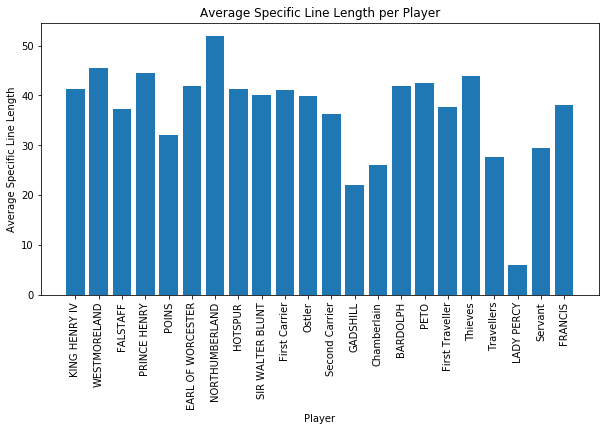

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

avg_line_length = shakespeare_df.head(1000)[["player", "player_line_length"]].groupby(["player"])\
    .apply(lambda row: np.average(row["player_line_length"]))
plt.bar(shakespeare_df.head(1000)["player"].unique(), avg_line_length)
plt.title("Average Specific Line Length per Player")
plt.xlabel("Player")
plt.xticks(rotation=90)
plt.ylabel("Average Specific Line Length")
plt.show()

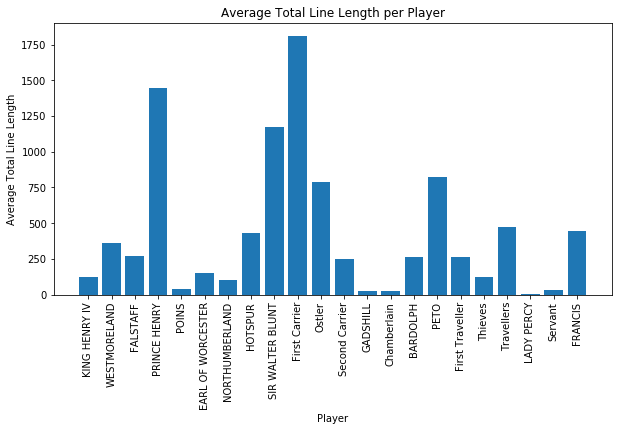

In [11]:
plt.figure(figsize=(10, 5))

avg_line_length = shakespeare_df.head(1000)[["player", "player_line_length_total"]].groupby(["player"])\
    .apply(lambda row: np.average(row["player_line_length_total"]))
plt.bar(shakespeare_df.head(1000)["player"].unique(), avg_line_length)
plt.title("Average Total Line Length per Player")
plt.xlabel("Player")
plt.xticks(rotation=90)
plt.ylabel("Average Total Line Length")
plt.show()

As you can see, the total line length is a much more promising feature than the specific line length due to the large standard deviation.

## Analysis - Determining Player
Now for the fun part! Let's start off by splitting our data into 2 categories: `Training` and `Testing`. We will split these up using the ratio of 4:1, and split them up randomly. The `Training` set will be used to train our models and will contain the features and the labels, and the `Testing` set will be used to test our models and will only contain features:

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

size_of_test = 50000 # This file was too big for me to test the entire dataset on my computer, so I will be using a subset
labels = shakespeare_df.head(size_of_test)["player"]
test_size = 0.20 # Test size is 20% of all rows

Let's go ahead and test our data using the features we discussed earlier:
- Play
- Act Number
- Scene Number

And play around with using some of these features as well:
- Length of Player Line
- Full Line Length

### Length of Player Line
The first feature we will test is the length of the player line:

In [13]:
# Splitting the data between 80% train and 20% test
features = shakespeare_df.head(size_of_test)[["play_ordinal", "act_number", "scene_number", "player_line_length"]]
training_f, testing_f, training_l, testing_l = train_test_split(features, labels, test_size=test_size)

#### Support Vector Machine

In [14]:
support_vector_classifier = SVC(gamma="auto")
support_vector_classifier.fit(training_f, training_l)
prediction = support_vector_classifier.predict(testing_f)
support_vector_classifier_accuracy = accuracy_score(prediction, testing_l)

#### Random Forest

In [15]:
random_forest = RandomForestClassifier(n_estimators=50)
random_forest.fit(training_f, training_l)
prediction = random_forest.predict(testing_f)
random_forest_accuracy = accuracy_score(prediction, testing_l)

In [16]:
print("Support Vector Machine Accuracy: %.4f%%" % support_vector_classifier_accuracy)
print("Random Forest Accuracy: %.4f%%" % random_forest_accuracy)

Support Vector Machine Accuracy: 0.3860%
Random Forest Accuracy: 0.4049%


Not surprisingly, the length of a player's individual lines is not very conducive to predicting the player of a given line. Let's try `full_line_length` now:

### Full Line Length

In [17]:
# Splitting the data between 80% train and 20% test
features = shakespeare_df.head(size_of_test)[["play_ordinal", "act_number", "scene_number", "player_line_length_total"]]
training_f, testing_f, training_l, testing_l = train_test_split(features, labels, test_size=test_size)

#### Support Vector Machine

In [18]:
support_vector_classifier = SVC(gamma="auto")
support_vector_classifier.fit(training_f, training_l)
prediction = support_vector_classifier.predict(testing_f)
support_vector_classifier_accuracy = accuracy_score(prediction, testing_l)

#### Random Forest

In [19]:
random_forest = RandomForestClassifier(n_estimators=50)
random_forest.fit(training_f, training_l)
prediction = random_forest.predict(testing_f)
random_forest_accuracy = accuracy_score(prediction, testing_l)

In [20]:
print("Support Vector Machine Accuracy: %.4f%%" % support_vector_classifier_accuracy)
print("Random Forest Accuracy: %.4f%%" % random_forest_accuracy)

Support Vector Machine Accuracy: 0.8337%
Random Forest Accuracy: 0.8858%


That is much better! It looks like our hypothesis was correct - the full line length is a _much_ better feature to use in classifying `player`!

## Conclusion

0.3860%
Random Forest Accuracy: 0.4049%

After testing a variety of features with different classification models, we have found that using a `Random Forest` classifier on `Player Full Line Length` produces the best results, with an accuracy of **0.8858%**. The `Support Vector Machine` model produces slightly worse results, with an accuracy of **0.8337%**. This discrepancy makes sense, as `Random Forests` are typically much more accurate than `SVMs` due to their size and procedures. `Random Forests` take into account all features as well as the probabilities of each feature in order to come to a prediction. `SVMs` on the other hand, simply try and separate the data as much as possible in order to classify.

Testing on the `Individual Player Line Length` proved to be a very weak way of classifying data. Similarly to `Player Full Line Length`, the `Random Forest` classifier was much more accurate than the `Support Vector Machine` classifier, with a difference of **0.4049%** and **0.3860%** respectively. Interestingly though, when run on a smaller dataset (around _10000_ entries), our `Support Vector Machine` classifier scored better than the `Random Forest` classifier. This could be due to the `player_line_length` data being very similar, which made it difficult for the `Random Forest` to notice smaller changes in the data as compared to the `SVM`, whose job is to find the small changes and make them larger so as to separate things more effectively.

### What Next?

Where could we go from here? Well, to start off with, we could use different classification models to see how they differ in their accuracy. A `Neural Network` would be a good thing to test with this data to presumably get accurate predictions.

We could also change the features that we train our models on to potentially boost accuracy. One feature that could prove to be promising is analyzing the content of the players' lines. For example, we could use natural language processing to find distinctions in players' sentence structure, or count uses of specific keywords. In the latter option, we could focus on the vocabulary of different characters to distinguish them from one another (for example, a king may use very powerful language, while a serf would use much more submissive language). These would potentially be very successful, but would take a while to implement.